In [2]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  # accessor needed to parse crs
import calendar
import argparse
import seaborn as sns
from shapely.geometry import Point
import geopandas
from geodatasets import get_path
import glob



In [3]:
tair = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/test_parallel_run/all_models_tair_by_year.csv')

In [8]:
tair = tair[['year','average','file']]

In [11]:
tair.loc[tair['year'].between(1500,1850), 'yr_group'] = 1850
tair.loc[tair['year'].between(1851,1925), 'yr_group'] = 1925
tair.loc[tair['year'].between(1926,1975), 'yr_group'] = 1975
tair.loc[tair['year'].between(1976,2014), 'yr_group'] = 2014
tair.loc[tair['year']>=2015, 'yr_group'] = tair['year']

In [15]:
tair = tair.groupby(['file','yr_group'])['average'].mean().reset_index()

In [26]:
t_1850 = tair.loc[tair['yr_group']==1850]
t_1850 = t_1850.rename(columns = {"average":"average_1850"})
t_1925 = tair.loc[tair['yr_group']==1925]
t_1925 = t_1925.rename(columns = {"average":"average_1925"})
t_1975 = tair.loc[tair['yr_group']==1975]
t_1975 = t_1975.rename(columns = {"average":"average_1975"})
t_2014 = tair.loc[tair['yr_group']==2014]
t_2014 = t_2014.rename(columns = {"average":"average_2014"})

In [21]:
print(len(t_1850))
print(len(t_1925))
print(len(t_1975))
print(len(t_2014))

38
38
38
38


In [35]:
compare = tair.loc[tair['yr_group']>=2015].merge(t_1850[['file','average_1850']], on = ['file']).merge(
t_1925[['file','average_1925']], on = ['file']
).merge(
t_1975[['file','average_1975']], on = ['file']
).merge(
t_2014[['file','average_2014']], on = ['file']
)

compare[['model','scenario','ext']] = compare['file'].str.split('_', expand=True)
tair[['model','scenario','ext']] = tair['file'].str.split('_', expand=True)

In [34]:
compare

,file,yr_group,average,average_1850,average_1925,average_1975,average_2014,model,scenario,ext
0,ACCESSxxCM2_ssp126_tair.csv,2015.0,283.214411,281.938306,281.670032,281.797239,282.225597,ACCESSxxCM2,ssp126,tair.csv
1,ACCESSxxCM2_ssp126_tair.csv,2016.0,283.476724,281.938306,281.670032,281.797239,282.225597,ACCESSxxCM2,ssp126,tair.csv
2,ACCESSxxCM2_ssp126_tair.csv,2017.0,283.225931,281.938306,281.670032,281.797239,282.225597,ACCESSxxCM2,ssp126,tair.csv
3,ACCESSxxCM2_ssp126_tair.csv,2018.0,283.118693,281.938306,281.670032,281.797239,282.225597,ACCESSxxCM2,ssp126,tair.csv
4,ACCESSxxCM2_ssp126_tair.csv,2019.0,283.534611,281.938306,281.670032,281.797239,282.225597,ACCESSxxCM2,ssp126,tair.csv
...,...,...,...,...,...,...,...,...,...,...
3223,MRIxxESM2xx0_ssp585_tair.csv,2096.0,289.381967,283.363920,283.237462,283.439942,283.844063,MRIxxESM2xx0,ssp585,tair.csv
3224,MRIxxESM2xx0_ssp585_tair.csv,2097.0,289.693548,283.363920,283.237462,283.439942,283.844063,MRIxxESM2xx0,ssp585,tair.csv
3225,MRIxxESM2xx0_ssp585_tair.csv,2098.0,289.329275,283.363920,283.237462,283.439942,283.844063,MRIxxESM2xx0,ssp585,tair.csv
3226,MRIxxESM2xx0_ssp585_tair.csv,2099.0,289.289413,283.363920,283.237462,283.439942,283.844063,MRIxxESM2xx0,ssp585,tair.csv


In [47]:
t_2080 = compare.loc[compare['yr_group']>=2080].groupby(['model','scenario'])[compare.columns[compare.columns.str.contains('aver')]].mean().reset_index()

t_2080

,model,scenario,average,average_1850,average_1925,average_1975,average_2014
0,ACCESSxxCM2,ssp126,285.226673,281.938306,281.670032,281.797239,282.225597
1,ACCESSxxCM2,ssp245,286.460111,281.938306,281.670032,281.797239,282.225597
2,ACCESSxxCM2,ssp370,288.029096,281.938306,281.670032,281.797239,282.225597
3,ACCESSxxCM2,ssp585,289.392482,281.938306,281.670032,281.797239,282.225597
4,AWIxxCMxx1xx1xxMR,ssp126,285.680640,282.908171,282.881025,283.238256,283.883479
5,AWIxxCMxx1xx1xxMR,ssp245,286.954431,282.908171,282.881025,283.238256,283.883479
6,AWIxxCMxx1xx1xxMR,ssp370,288.399063,282.908171,282.881025,283.238256,283.883479
7,AWIxxCMxx1xx1xxMR,ssp585,289.540360,282.908171,282.881025,283.238256,283.883479
8,BCCxxCSM2xxMR,ssp126,284.377010,281.912468,282.038525,282.257051,282.732424
9,BCCxxCSM2xxMR,ssp245,285.735955,281.912468,282.038525,282.257051,282.732424


In [48]:
t_2080['change_1975'] = t_2080['average']/t_2080['average_1975']

<Axes: xlabel='scenario', ylabel='model'>

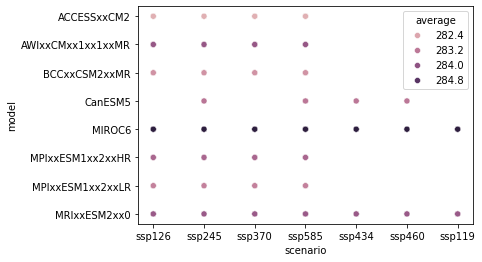

In [37]:
sns.scatterplot(data =tair.loc[tair['yr_group']<2015], x = 'scenario',y='model',hue = 'average')

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'ACCESSxxCM2'),
  Text(1, 0, 'AWIxxCMxx1xx1xxMR'),
  Text(2, 0, 'BCCxxCSM2xxMR'),
  Text(3, 0, 'CanESM5'),
  Text(4, 0, 'MIROC6'),
  Text(5, 0, 'MPIxxESM1xx2xxHR'),
  Text(6, 0, 'MPIxxESM1xx2xxLR'),
  Text(7, 0, 'MRIxxESM2xx0')])

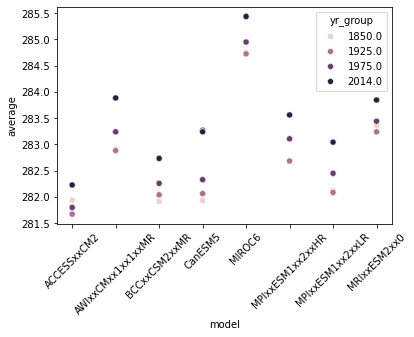

In [40]:
sns.scatterplot(data =tair.loc[tair['yr_group']<2015], x = 'model',y='average',hue = 'yr_group')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'ACCESSxxCM2'),
  Text(1, 0, 'AWIxxCMxx1xx1xxMR'),
  Text(2, 0, 'BCCxxCSM2xxMR'),
  Text(3, 0, 'CanESM5'),
  Text(4, 0, 'MIROC6'),
  Text(5, 0, 'MPIxxESM1xx2xxHR'),
  Text(6, 0, 'MPIxxESM1xx2xxLR'),
  Text(7, 0, 'MRIxxESM2xx0')])

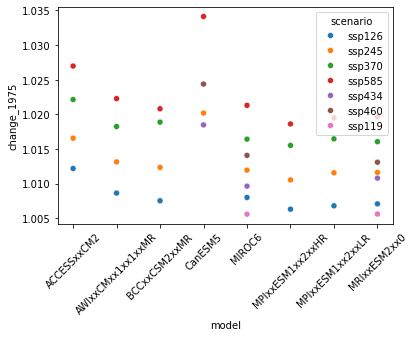

In [49]:
sns.scatterplot(data =t_2080, x = 'model',y='change_1975',hue = 'scenario')
plt.xticks(rotation=45)